In [1]:
import numpy as np
from numba import jit

from py.model import *
from py.scores import *

import pandas as pd
# from SpringRank import SpringRank

from matplotlib import pyplot as plt

from scipy.optimize import root, minimize
from scipy.optimize.slsqp import approx_jacobian
from itertools import product

from autograd import jacobian


import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

In [2]:
cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']

In [3]:
def compute_gamma(s, beta):
    gamma = np.exp(beta*s)
    gamma = gamma/gamma.sum()
    return(gamma)

def make_s(s_1, s_2, n_1, n):
        
    s_1 = s_1
    s_2 = s_2
    
    n_1 = int(n_1)
    n_2 = n - n_1
    
    s = np.zeros(n)
    s[0:n_1] += 1*s_1
    s[n_1:n] += 1*s_2
#     s = s - (s.sum()-1)/n 
    return(s)

def make_gamma(s_1, s_2, n_1, n, beta):
    s = make_s(s_1, s_2, n_1, n)

    return(compute_gamma(np.sqrt(s), beta)) # for root-degree score

def f(s_1, s_2, n_1, n, beta, alpha, max_iters = 200, tol = 10**(-5)):
    n = int(n)
    s = make_s(s_1, s_2, n_1, n)
    gamma = compute_gamma(s, beta)
    
    for i in range(max_iters):
        s_old = s.copy()
        gamma = compute_gamma(s, beta)
        G = np.tile(gamma, (n,1))

        E = np.ones((n,n))

        eigs = np.linalg.eig(G.T + (1-alpha)/(alpha*n)*E)
        which_eig = np.argmax(np.abs(eigs[0]))
        v = np.abs(eigs[1][:,which_eig])
        s = v / v.sum()
        s = -np.sort(-s)
        
        # smoothing: 
        for i in range(n):
            for j in range(n):
                if np.abs(s[i] - s[j]) < 10**(-4):
                    s[j] = s[i]
        
        if np.sqrt(((s - s_old)**2).sum()) < tol:
            return(
                pd.Series([s[0], s[-1]], index = ['s_1', 's_2'])
            )
    return(
        pd.Series([s[0], s[-1]], index = ['s_1', 's_2'])
    )
        

def g(row):
    return(f(row.s_1_0, row.s_2_0, row.n_1, row.n, row.beta, max_iters = 5000, tol = 10**(-8), alpha = 0.85))     

In [4]:
f(.4, .1, 3, 10, 11, 0.85)

s_1    0.240477
s_2    0.039796
dtype: float64

So, we'd like to organize this calculation in a nicer fashion. One way to do this will be to build up a data frame, sort on certain features, and then group them appropriately. We'll need iterators for n_1 and beta. We'll also need to allow for multiple solutions...

# Compute the space of solutions

In [8]:
BETA_GRID = np.linspace(0, 20, 101)
n_1   = np.arange(1, 10)
s1 = [3, 1.00000001]
s2 = [1]

n = 10

df = pd.DataFrame(list(product(BETA_GRID, n_1, s1, s2)), columns=['beta', 'n_1', 's_1_0', 's_2_0'])


df['n'] = n

df = pd.concat([df, df.apply(lambda row: g(row), 
                             axis = 1, 
                             result_type='expand')], 
               axis = 1) # compute a bunch of equilibria

In [9]:
df = df.sort_values(['beta', 'n_1', 's_1'])
df = df[df.s_1.notnull()]
df['s_1'] = np.round(df.s_1, 3)
df['s_2'] = np.round(df.s_2, 3)
# df['s1'] = df[['s_1', 's_2']].max(axis = 1)
# df['s2'] = df[['s_1', 's_2']].min(axis = 1)
df = df.drop_duplicates(['n_1', 'beta', 's_1', 's_2'])
# df = df.drop(['s_1', 's_2', 'rep'], axis = 1)
df['group'] = df.groupby(['beta', 'n_1'])['s_1'].rank(method = 'first')

# df['group_2'] = np.around((np.abs(df.s1 - df.s2)),1) 

df = df.drop(['s_1_0', 's_2_0', 'n'], axis = 1)
# df['nonegalitarian'] = (np.abs(df.s1 - df.s2) > .01)

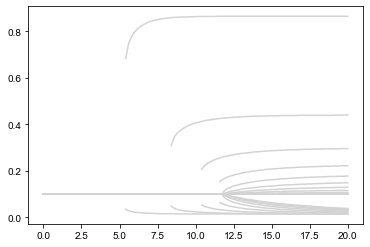

In [10]:
p = df.groupby(['n_1',  'group']).apply(lambda g: plt.plot(g.beta, g.s_1, color = 'lightgrey', zorder = 1))
p = df.groupby(['n_1',  'group']).apply(lambda g: plt.plot(g.beta, g.s_2, color = 'lightgrey', zorder = 1))
# plt.semilogy()

# Stability

In [11]:
def numerical_jacobian(n_1, s_1, s_2, n, beta, alpha):
    
    # lives in n x n space
    s = make_s(s_1, s_2, n_1, n)
    gamma = compute_gamma(s, beta)
    G = np.tile(gamma, (n,1))
    
    return(-alpha*n*(1/alpha*np.eye(n) - G.T - beta*(np.diag(gamma) - np.outer(gamma, gamma))))


In [12]:
def test_stable_(n_1, s_1, s_2, n, beta, alpha):
    '''
    '''
    J = numerical_jacobian(n_1, s_1, s_2, n, beta, alpha) 

    eigs = np.linalg.eig(J)

    
    
    if eigs[0].max() < 0:
        linearly_stable = True
    else:
        linearly_stable = False
    return(linearly_stable)

In [13]:
df['stable'] = df.apply(lambda row: test_stable_(row.n_1, row.s_1, row.s_2, n, row.beta, alpha = 0.85), axis = 1)

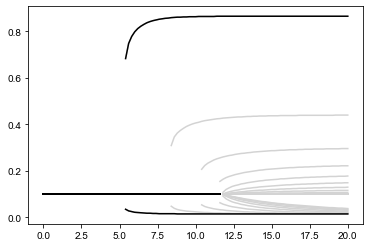

In [14]:
colors = ['lightgrey', 'black']
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_1, zorder = 1, color = colors[0]))
p = df.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_2, zorder = 1, color = colors[0]))

df_sub = df[df.stable]
p = df_sub.groupby(['n_1','group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_1, zorder = 1, color = colors[1]))
p = df_sub.groupby(['n_1', 'group', 'stable']).apply(lambda g: plt.plot(g.beta, g.s_2, zorder = 1, color = colors[1]))

In [17]:
df.to_csv('throughput/pagerank_score_curves.csv', index = False)